In [ ]:
#import libaries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

pd.set_option('display.max_colwidth',1000)

#import data
fractal_df = pd.read_csv('/content/drive/Shareddrives/Gorlewski_Soot_Restructuring_Deep_Learning/Restructuring Data/Run#133/parametersCSV.csv',header=None)


# **Data Processing & Visualization**

In [ ]:
# process fractal dimension data

#check for null values
fractal_df.isnull().values.any()

for column in range(1,6):
  fractal_df = fractal_df.drop(columns=column)

fractal_df.columns = ['Fractal Dimension']
fractal_df = fractal_df.drop(index=0)
fractal_df['Fractal Dimension'] = fractal_df['Fractal Dimension'].astype(float).round(4)
display(fractal_df)

,Fractal Dimension
1,1.7799
2,1.7800
3,1.7800
4,1.7801
5,1.7802
...,...
13530,2.4519
13531,2.4519
13532,2.4519
13533,2.4519


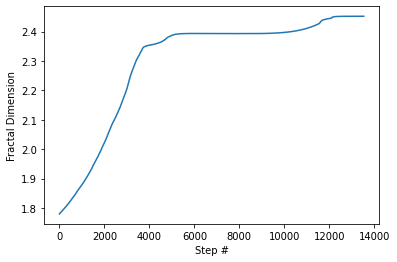

In [ ]:
#visualize the change in fractal dimension over timesteps
x_axis = np.linspace(0,13534,num=13534, endpoint=False)
plt.plot((x_axis),fractal_df['Fractal Dimension'])
plt.xlabel('Step #')
plt.ylabel('Fractal Dimension')
plt.show()


## **Initialize Data for Models**

In [ ]:

#make into a vector
data = fractal_df['Fractal Dimension'].values.reshape(-1,1)

# split the data into train and test sets
def split_data(dat, lookback):
    data_raw = dat
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.5*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 125 # choose sequence length
x_train, y_train, x_test, y_test = split_data(data, lookback)
train_dataset = TensorDataset(torch.tensor(x_train,dtype=torch.float64),torch.tensor(y_train,dtype=torch.float64))
dataloader = DataLoader(train_dataset,batch_size=256,shuffle=False)
test_dataset = TensorDataset(torch.tensor(x_test,dtype=torch.float64),torch.tensor(y_test,dtype=torch.float64))
testloader = DataLoader(test_dataset,batch_size=1,shuffle=False)

# **Vanilla RNN**

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.rnn(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

input_dim = 1
hidden_dim = 128
num_layers = 3
output_dim = 1
num_epochs = 100

In [ ]:

#train
model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.L1Loss()
optimiser = torch.optim.RMSprop(model.parameters(), lr=5e-6)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser,gamma=0.5)

import time
hist = np.zeros(num_epochs)
start_time = time.time()
rnn = []
for t in range(num_epochs):
  for id_batch, (x_batch,y_batch) in enumerate(dataloader):
      y_batch_pred = model(x_batch.float())
      loss = criterion(y_batch_pred, y_batch)
      
      hist[t] = loss.item()
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
      #scheduler.step()
  print("Epoch ", t, "Loss: ", loss.item())
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 Loss:  2.126591920852661
Epoch  1 Loss:  1.9794132709503174
Epoch  2 Loss:  1.8344192504882812
Epoch  3 Loss:  1.6824910640716553
Epoch  4 Loss:  1.5210000276565552
Epoch  5 Loss:  1.34979248046875
Epoch  6 Loss:  1.1699458360671997
Epoch  7 Loss:  0.9832554459571838
Epoch  8 Loss:  0.791886568069458
Epoch  9 Loss:  0.598170280456543
Epoch  10 Loss:  0.40433627367019653
Epoch  11 Loss:  0.26880788803100586
Epoch  12 Loss:  0.18468600511550903
Epoch  13 Loss:  0.12870271503925323
Epoch  14 Loss:  0.09085708111524582
Epoch  15 Loss:  0.06238798797130585
Epoch  16 Loss:  0.040364544838666916
Epoch  17 Loss:  0.02284150756895542
Epoch  18 Loss:  0.010464484803378582
Epoch  19 Loss:  0.0017607721965759993
Epoch  20 Loss:  0.003749324008822441
Epoch  21 Loss:  0.000788968347478658
Epoch  22 Loss:  0.004738284274935722
Epoch  23 Loss:  0.00016718731785658747
Epoch  24 Loss:  0.005366279743611813
Epoch  25 Loss:  0.0003237263299524784
Epoch  26 Loss:  0.0027900205459445715
Epoch  27 L

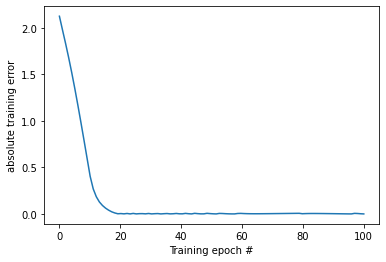

In [ ]:
plt.plot(np.linspace(0,100,num=100),hist)
plt.xlabel("Training epoch #")
plt.ylabel("absolute training error")
plt.show()

In [ ]:
#Save trained Vanilla RNN model
torch.save(model.state_dict(), '/content/drive/Shareddrives/Gorlewski_Soot_Restructuring_Deep_Learning/vanillaRNN_trained.pth')

## **Load Vanilla RNN Model (for TA)**

In [ ]:
model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.load_state_dict(torch.load('/content/drive/Shareddrives/Gorlewski_Soot_Restructuring_Deep_Learning/vanillaRNN_trained.pth'))

<All keys matched successfully>

## **Testing Vanilla RNN**

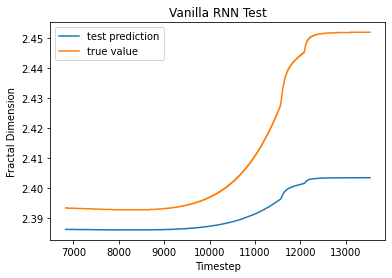

Total MSE Testing Loss: 0.0007320566007989524


In [ ]:
#testing
results_vanilla = []
test_error_vanilla = []
model.eval()
test_model_vanilla = model
for id_batch,(x_batch,y_batch) in enumerate(testloader):
  with torch.no_grad():
    test_model_vanilla.hidden = (torch.zeros(1, 1, model.hidden_dim),torch.zeros(1, 1, model.hidden_dim))
    y_batch_pred_vanilla = test_model_vanilla(x_batch.float())
    test_error_vanilla.append((y_batch_pred_vanilla-y_batch)**2)
    results_vanilla.append(y_batch_pred_vanilla)

#print(len(results_vanilla))
#print("#"*80)
#print(results_vanilla)

plt.plot(np.linspace(6830,13534,num=6704),results_vanilla,label='test prediction')
plt.plot(np.linspace(6830,13534,num=6704),y_test,label='true value')
plt.title('Vanilla RNN Test')
plt.xlabel('Timestep')
plt.ylabel('Fractal Dimension')
plt.legend(loc="upper left")
plt.show()
total_test_loss_vanilla = sum(test_error_vanilla)*(1/(len(test_error_vanilla)))
print("Total MSE Testing Loss: {}".format(float(total_test_loss_vanilla)))

# **LSTM**

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
#train
input_dim = 1
hidden_dim = 128
num_layers = 3
output_dim = 1
num_epochs = 100

model_lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.L1Loss()
optimiser = torch.optim.RMSprop(model_lstm.parameters(), lr=5e-6)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser,gamma=0.9)

import time
hist_lstm = np.zeros(num_epochs)
start_time = time.time()
rnn = []
for t in range(num_epochs):
  for id_batch, (x_batch,y_batch) in enumerate(dataloader):
      y_batch_pred = model_lstm(x_batch.float())
      loss = criterion(y_batch_pred, y_batch)
      
      hist_lstm[t] = loss.item()
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
      #scheduler.step()
  print("Epoch ", t, "Loss: ", loss.item())

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 Loss:  2.3833792209625244
Epoch  1 Loss:  2.368488311767578
Epoch  2 Loss:  2.3556149005889893
Epoch  3 Loss:  2.343414545059204
Epoch  4 Loss:  2.3313424587249756
Epoch  5 Loss:  2.3190765380859375
Epoch  6 Loss:  2.3063900470733643
Epoch  7 Loss:  2.293095588684082
Epoch  8 Loss:  2.2790205478668213
Epoch  9 Loss:  2.263991355895996
Epoch  10 Loss:  2.2478132247924805
Epoch  11 Loss:  2.230255365371704
Epoch  12 Loss:  2.211040496826172
Epoch  13 Loss:  2.189832925796509
Epoch  14 Loss:  2.166221857070923
Epoch  15 Loss:  2.1396851539611816
Epoch  16 Loss:  2.1095619201660156
Epoch  17 Loss:  2.0750160217285156
Epoch  18 Loss:  2.0349600315093994
Epoch  19 Loss:  1.9879624843597412
Epoch  20 Loss:  1.9320954084396362
Epoch  21 Loss:  1.864742398262024
Epoch  22 Loss:  1.782381534576416
Epoch  23 Loss:  1.680420994758606
Epoch  24 Loss:  1.5531996488571167
Epoch  25 Loss:  1.3946926593780518
Epoch  26 Loss:  1.200644850730896
Epoch  27 Loss:  0.9719899892807007
Epoch  28 Loss

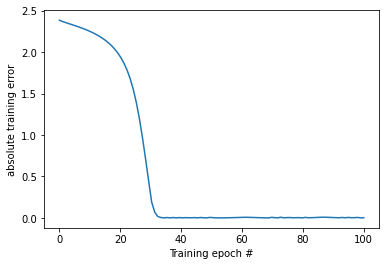

In [ ]:
plt.plot(np.linspace(0,100,num=100),hist_lstm)
plt.xlabel("Training epoch #")
plt.ylabel("absolute training error")
plt.show()

In [ ]:
#Save trained LSTM model
torch.save(model_lstm.state_dict(), '/content/drive/Shareddrives/Gorlewski_Soot_Restructuring_Deep_Learning/LSTM_trained.pth')

## **Load LSTM Model (for TA)**

In [ ]:
model_lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model_lstm.load_state_dict(torch.load('/content/drive/Shareddrives/Gorlewski_Soot_Restructuring_Deep_Learning/LSTM_trained.pth'))

<All keys matched successfully>

## **LSTM Testing**

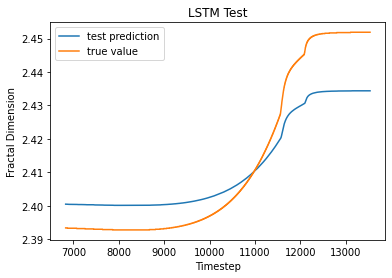

Total MSE Testing Loss: 0.00010476388588225918


In [ ]:
#testing
results_lstm = []
test_error_lstm = []
model_lstm.eval()
test_model_lstm = model_lstm
for id_batch,(x_batch,y_batch) in enumerate(testloader):
  with torch.no_grad():
    test_model_lstm.hidden = (torch.zeros(1, 1, model_lstm.hidden_dim),torch.zeros(1, 1, model_lstm.hidden_dim))
    y_batch_pred_lstm = test_model_lstm(x_batch.float())
    test_error_lstm.append((y_batch_pred_lstm-y_batch)**2)
    results_lstm.append(y_batch_pred_lstm)
plt.plot(np.linspace(6830,13534,num=6704),results_lstm,label='test prediction')
plt.plot(np.linspace(6830,13534,num=6704),y_test,label='true value')
plt.title('LSTM Test')
plt.xlabel('Timestep')
plt.ylabel('Fractal Dimension')
plt.legend(loc="upper left")
plt.show()
total_test_loss_lstm = sum(test_error_lstm)*(1/(len(test_error_lstm)))
print("Total MSE Testing Loss: {}".format(float(total_test_loss_lstm)))

# **GRU**

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
#train
input_dim = 1
hidden_dim = 128
num_layers = 3
output_dim = 1
num_epochs = 100

model_gru = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.L1Loss()
optimiser = torch.optim.RMSprop(model_gru.parameters(), lr=5e-6)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser,gamma=0.9)

import time
hist_gru = np.zeros(num_epochs)
start_time = time.time()
rnn = []
for t in range(num_epochs):
  for id_batch, (x_batch,y_batch) in enumerate(dataloader):
      y_batch_pred_gru = model_gru(x_batch.float())
      loss = criterion(y_batch_pred_gru, y_batch)
      
      hist_gru[t] = loss.item()
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
      #scheduler.step()
  print("Epoch ", t, "Loss: ", loss.item())

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 Loss:  2.265444040298462
Epoch  1 Loss:  2.212305784225464
Epoch  2 Loss:  2.1657190322875977
Epoch  3 Loss:  2.120805501937866
Epoch  4 Loss:  2.0755977630615234
Epoch  5 Loss:  2.0289535522460938
Epoch  6 Loss:  1.980026364326477
Epoch  7 Loss:  1.9281105995178223
Epoch  8 Loss:  1.8726006746292114
Epoch  9 Loss:  1.8129674196243286
Epoch  10 Loss:  1.7486979961395264
Epoch  11 Loss:  1.6792601346969604
Epoch  12 Loss:  1.6040962934494019
Epoch  13 Loss:  1.5226480960845947
Epoch  14 Loss:  1.4343822002410889
Epoch  15 Loss:  1.338818907737732
Epoch  16 Loss:  1.2355716228485107
Epoch  17 Loss:  1.124361515045166
Epoch  18 Loss:  1.0049830675125122
Epoch  19 Loss:  0.8772709369659424
Epoch  20 Loss:  0.7411175966262817
Epoch  21 Loss:  0.596552848815918
Epoch  22 Loss:  0.44385531544685364
Epoch  23 Loss:  0.2836127281188965
Epoch  24 Loss:  0.14272648096084595
Epoch  25 Loss:  0.07228831201791763
Epoch  26 Loss:  0.030751993879675865
Epoch  27 Loss:  0.003972338512539864
Ep

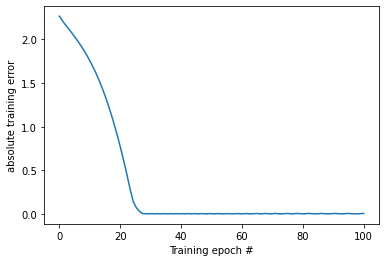

In [ ]:
plt.plot(np.linspace(0,100,num=100),hist_gru)
plt.xlabel("Training epoch #")
plt.ylabel("absolute training error")
plt.show()

In [ ]:
#save trained GRU model
torch.save(model_gru.state_dict(), '/content/drive/Shareddrives/Gorlewski_Soot_Restructuring_Deep_Learning/GRU_trained.pth')

## **Load GRU Model (For TA)**

In [ ]:
model_gru = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model_gru.load_state_dict(torch.load('/content/drive/Shareddrives/Gorlewski_Soot_Restructuring_Deep_Learning/GRU_trained.pth'))

<All keys matched successfully>

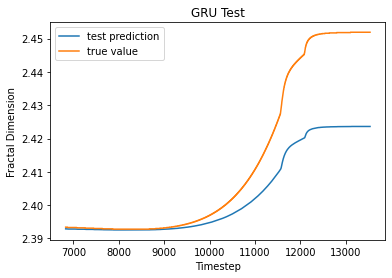

Total MSE Testing Loss: 0.00022870572273863814


In [ ]:
#testing
results_gru = []
test_error_gru = []
model_gru.eval()
test_model_gru = model_gru
for id_batch,(x_batch,y_batch) in enumerate(testloader):
  with torch.no_grad():
    test_model_gru.hidden = (torch.zeros(1, 1, model_gru.hidden_dim),torch.zeros(1, 1, model_gru.hidden_dim))
    y_batch_pred_gru = test_model_gru(x_batch.float())
    test_error_gru.append((y_batch_pred_gru-y_batch)**2)
    results_gru.append(y_batch_pred_gru)
plt.plot(np.linspace(6830,13534,num=6704),results_gru,label='test prediction')
plt.plot(np.linspace(6830,13534,num=6704),y_test,label='true value')
plt.title('GRU Test')
plt.xlabel('Timestep')
plt.ylabel('Fractal Dimension')
plt.legend(loc="upper left")
plt.show()
total_test_loss_gru = sum(test_error_gru)*(1/(len(test_error_gru)))
print("Total MSE Testing Loss: {}".format(float(total_test_loss_gru)))